# Ağ Anomali Tespiti - Unsupervised Learning Yaklaşımları

Bu notebook, KDD Cup 1999 veri seti üzerinde unsupervised learning yöntemleri kullanarak ağ anomali tespiti gerçekleştirir.

## Kullanılan Yöntemler:
- **K-means Clustering**: Veri noktalarını kümelere ayırarak anomalileri tespit
- **DBSCAN**: Yoğunluk tabanlı kümeleme ile outlier tespiti
- **Isolation Forest**: Anomali tespiti için özel tasarlanmış algoritma
- **One-Class SVM**: Tek sınıf sınıflandırması ile anomali tespiti
- **Local Outlier Factor (LOF)**: Yerel yoğunluk tabanlı anomali tespiti

## Hedefler:
1. Farklı unsupervised algoritmaları karşılaştırmak
2. Anomali skorlarını görselleştirmek
3. Kümeleme sonuçlarını analiz etmek
4. En etkili yöntemi belirlemek

In [1]:
# Gerekli kütüphaneleri import et
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Veri Yükleme ve Ön İşleme

In [2]:
# Veri yükleme
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# KDD Cup 1999 kolon isimleri
KDD_COLS = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

# Veriyi yükle
print("Veri yükleniyor...")
data_path = Path('../data/kddcup.data_10_percent.gz')
df = pd.read_csv(data_path, names=KDD_COLS, header=None, compression='gzip')

print(f"Toplam veri boyutu: {df.shape}")

# Özellikleri ve etiketleri ayır
X = df.drop('label', axis=1)
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Binary etiketler oluştur (0: normal, 1: anomali)
y_train_binary = (y_train != 'normal.').astype(int)
y_test_binary = (y_test != 'normal.').astype(int)

print(f"Eğitim setinde normal: {sum(y_train_binary == 0)}, anomali: {sum(y_train_binary == 1)}")
print(f"Test setinde normal: {sum(y_test_binary == 0)}, anomali: {sum(y_test_binary == 1)}")

Veri yükleniyor...


Toplam veri boyutu: (494021, 42)


Eğitim seti boyutu: (395216, 41)
Test seti boyutu: (98805, 41)
Eğitim setinde normal: 77822, anomali: 317394
Test setinde normal: 19456, anomali: 79349


In [3]:
# Veri ön işleme
print("Veri ön işleme yapılıyor...")

# Kategorik değişkenleri encode et
from sklearn.preprocessing import LabelEncoder

# Kategorik kolonları belirle
categorical_cols = ['protocol_type', 'service', 'flag']

# Label encoding
le_dict = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    # Tüm benzersiz değerleri birleştir
    all_values = pd.concat([X_train[col], X_test[col]]).unique()
    le.fit(all_values)
    
    X_train_encoded[col] = le.transform(X_train[col])
    X_test_encoded[col] = le.transform(X_test[col])
    le_dict[col] = le

print("Kategorik değişkenler encode edildi.")

# Sabit kolonları kaldır
constant_cols = X_train_encoded.columns[X_train_encoded.nunique() <= 1]
if len(constant_cols) > 0:
    print(f"Sabit kolonlar kaldırılıyor: {list(constant_cols)}")
    X_train_encoded = X_train_encoded.drop(columns=constant_cols)
    X_test_encoded = X_test_encoded.drop(columns=constant_cols)

print(f"İşlenmiş veri boyutu: {X_train_encoded.shape}")

Veri ön işleme yapılıyor...


Kategorik değişkenler encode edildi.
Sabit kolonlar kaldırılıyor: ['num_outbound_cmds', 'is_host_login']
İşlenmiş veri boyutu: (395216, 39)


In [4]:
# Veriyi normalize et
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Veri normalizasyonu tamamlandı.")

# Anomali tespiti için sadece normal verileri kullan (unsupervised)
normal_indices = y_train_binary == 0
X_train_normal = X_train_scaled[normal_indices]

print(f"Normal veri boyutu (eğitim için): {X_train_normal.shape}")

# Performans değerlendirmesi için küçük bir subset kullan
np.random.seed(42)
sample_size = min(10000, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]
y_test_sample = y_test_binary.iloc[sample_indices]

print(f"Test sample boyutu: {X_test_sample.shape}")

Veri normalizasyonu tamamlandı.
Normal veri boyutu (eğitim için): (77822, 39)
Test sample boyutu: (10000, 39)


## 2. Boyut Azaltma ve Görselleştirme

In [5]:
# PCA ile boyut azaltma
print("PCA ile boyut azaltma yapılıyor...")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_normal[:5000])  # Hız için subset
X_test_pca = pca.transform(X_test_sample)

print(f"PCA açıklanan varyans oranı: {pca.explained_variance_ratio_}")
print(f"Toplam açıklanan varyans: {pca.explained_variance_ratio_.sum():.3f}")

PCA ile boyut azaltma yapılıyor...
PCA açıklanan varyans oranı: [0.17762279 0.15297266]
Toplam açıklanan varyans: 0.331


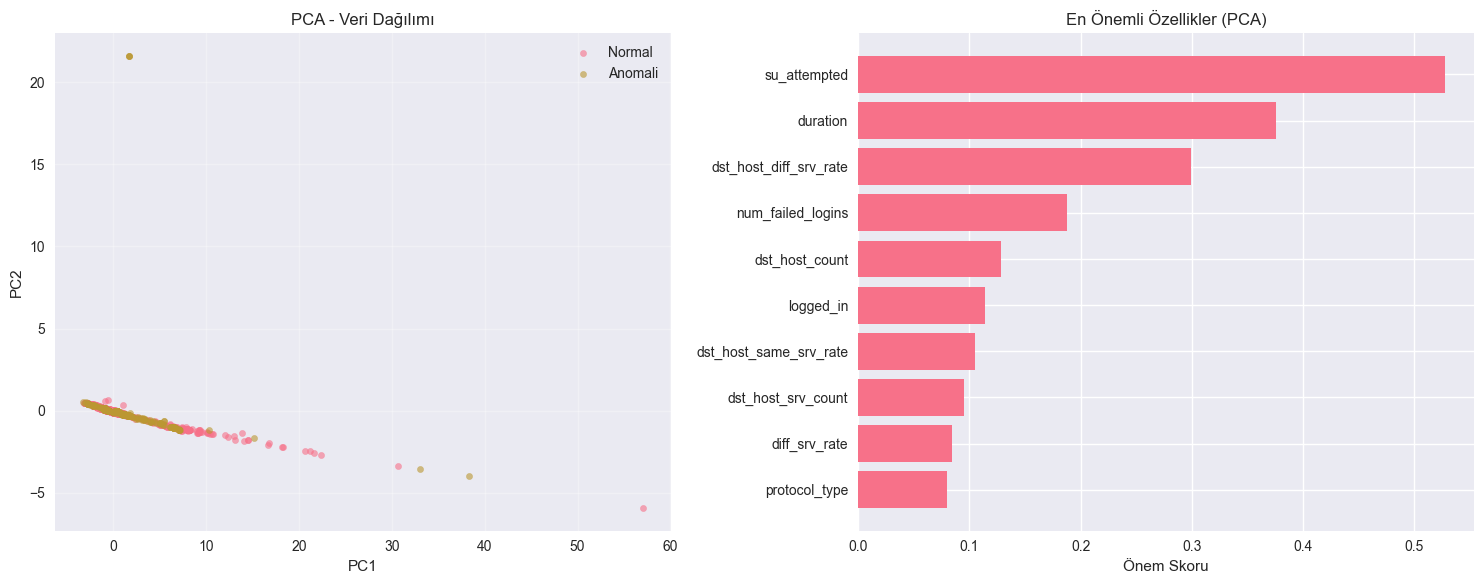

In [6]:
# Veri dağılımını görselleştir
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA sonuçları
axes[0].scatter(X_test_pca[y_test_sample == 0, 0], X_test_pca[y_test_sample == 0, 1], 
               alpha=0.6, label='Normal', s=20)
axes[0].scatter(X_test_pca[y_test_sample == 1, 0], X_test_pca[y_test_sample == 1, 1], 
               alpha=0.6, label='Anomali', s=20)
axes[0].set_title('PCA - Veri Dağılımı')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Özellik önemlerini göster
feature_importance = np.abs(pca.components_).mean(axis=0)
top_features = np.argsort(feature_importance)[-10:]

axes[1].barh(range(len(top_features)), feature_importance[top_features])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels([X_train_encoded.columns[i] for i in top_features])
axes[1].set_title('En Önemli Özellikler (PCA)')
axes[1].set_xlabel('Önem Skoru')

plt.tight_layout()
plt.show()

## 3. K-means Clustering

K-means için optimal küme sayısı belirleniyor...


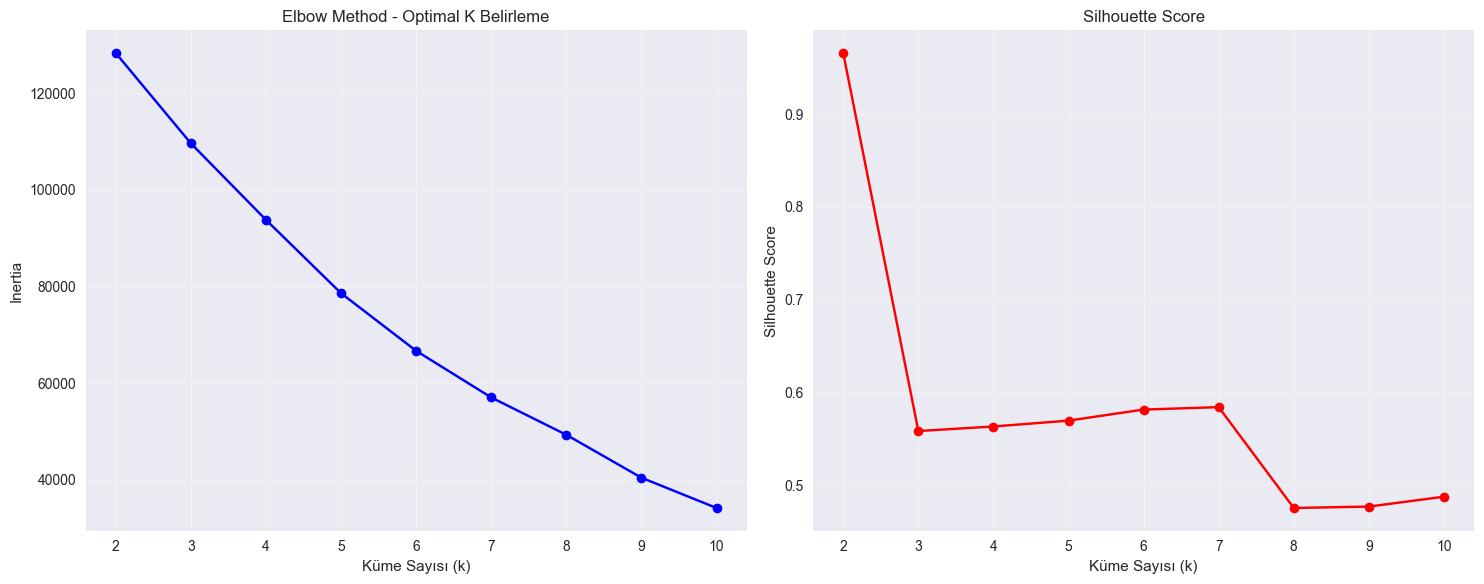

En iyi küme sayısı: 2 (Silhouette Score: 0.966)


In [7]:
# Optimal küme sayısını bul (Elbow method)
print("K-means için optimal küme sayısı belirleniyor...")

k_range = range(2, 11)
inertias = []
silhouette_scores = []

# Hız için daha küçük sample
sample_normal = X_train_normal[:3000]

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sample_normal)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sample_normal, labels))

# Sonuçları görselleştir
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_title('Elbow Method - Optimal K Belirleme')
axes[0].set_xlabel('Küme Sayısı (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Küme Sayısı (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# En iyi k değerini seç
best_k = k_range[np.argmax(silhouette_scores)]
print(f"En iyi küme sayısı: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})")

In [8]:
# K-means ile anomali tespiti
print(f"K-means clustering (k={best_k}) uygulanıyor...")

# Normal veriler üzerinde eğit
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(X_train_normal)

# Test verisi üzerinde tahmin yap
test_labels = kmeans.predict(X_test_sample)
test_distances = kmeans.transform(X_test_sample)

# Her nokta için en yakın küme merkezine olan mesafeyi hesapla
min_distances = np.min(test_distances, axis=1)

# Anomali skorunu hesapla (yüksek mesafe = yüksek anomali skoru)
anomaly_scores_kmeans = min_distances

# Threshold belirleme (95. percentile)
threshold_kmeans = np.percentile(anomaly_scores_kmeans, 95)
predictions_kmeans = (anomaly_scores_kmeans > threshold_kmeans).astype(int)

print(f"K-means threshold: {threshold_kmeans:.3f}")
print(f"Tespit edilen anomali sayısı: {sum(predictions_kmeans)}")

K-means clustering (k=2) uygulanıyor...


K-means threshold: 10.095
Tespit edilen anomali sayısı: 500


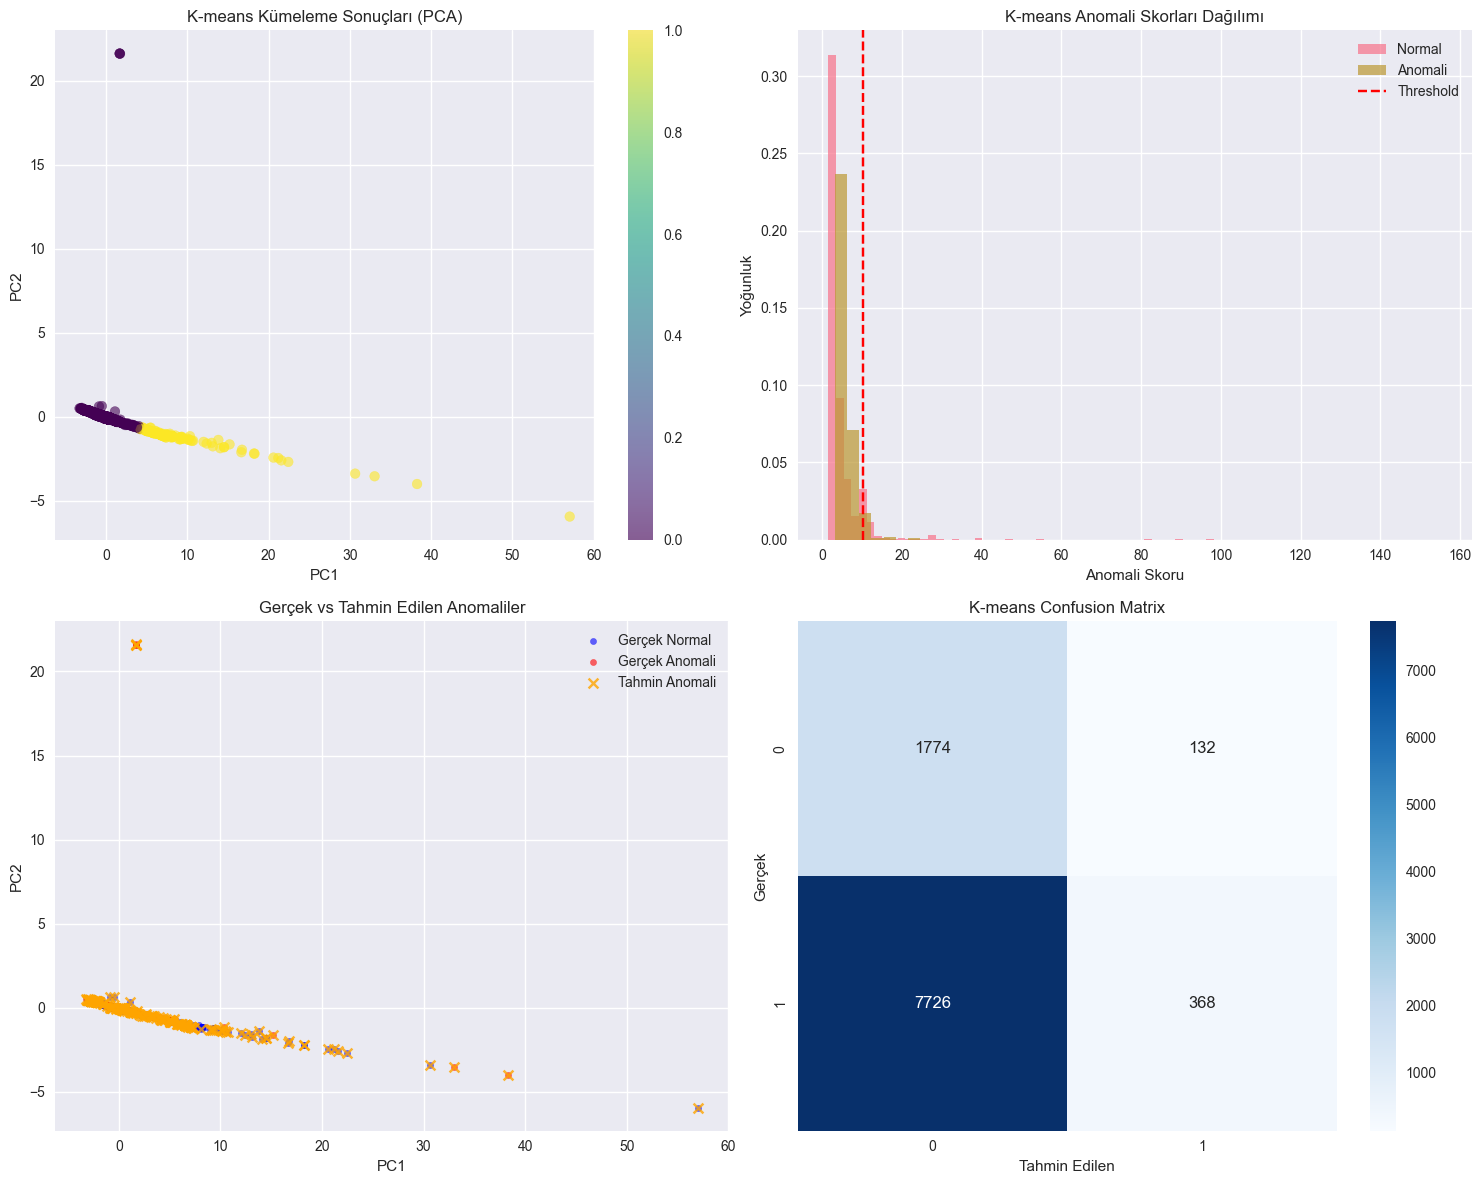

In [9]:
# K-means sonuçlarını görselleştir
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PCA ile boyut indirgeme sonrası K-means eğitimi
kmeans_pca = KMeans(n_clusters=best_k, random_state=42, n_init=10)
X_train_pca_normal = pca.transform(X_train_normal)
kmeans_pca.fit(X_train_pca_normal)

# Test verisi üzerinde tahmin yap (PCA)
test_labels_pca = kmeans_pca.predict(X_test_pca)
scatter = axes[0,0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels_pca, cmap='viridis', alpha=0.6)
axes[0,0].set_title('K-means Kümeleme Sonuçları (PCA)')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
plt.colorbar(scatter, ax=axes[0,0])

# Anomali skorları dağılımı
axes[0,1].hist(anomaly_scores_kmeans[y_test_sample == 0], bins=50, alpha=0.7, label='Normal', density=True)
axes[0,1].hist(anomaly_scores_kmeans[y_test_sample == 1], bins=50, alpha=0.7, label='Anomali', density=True)
axes[0,1].axvline(threshold_kmeans, color='red', linestyle='--', label='Threshold')
axes[0,1].set_title('K-means Anomali Skorları Dağılımı')
axes[0,1].set_xlabel('Anomali Skoru')
axes[0,1].set_ylabel('Yoğunluk')
axes[0,1].legend()

# Gerçek vs Tahmin edilen
axes[1,0].scatter(X_test_pca[y_test_sample == 0, 0], X_test_pca[y_test_sample == 0, 1], 
                 alpha=0.6, label='Gerçek Normal', s=20, c='blue')
axes[1,0].scatter(X_test_pca[y_test_sample == 1, 0], X_test_pca[y_test_sample == 1, 1], 
                 alpha=0.6, label='Gerçek Anomali', s=20, c='red')
axes[1,0].scatter(X_test_pca[predictions_kmeans == 1, 0], X_test_pca[predictions_kmeans == 1, 1], 
                 alpha=0.8, label='Tahmin Anomali', s=50, c='orange', marker='x')
axes[1,0].set_title('Gerçek vs Tahmin Edilen Anomaliler')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].legend()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_sample, predictions_kmeans)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('K-means Confusion Matrix')
axes[1,1].set_xlabel('Tahmin Edilen')
axes[1,1].set_ylabel('Gerçek')

plt.tight_layout()
plt.show()

## 4. DBSCAN Clustering

DBSCAN parametreleri optimize ediliyor...


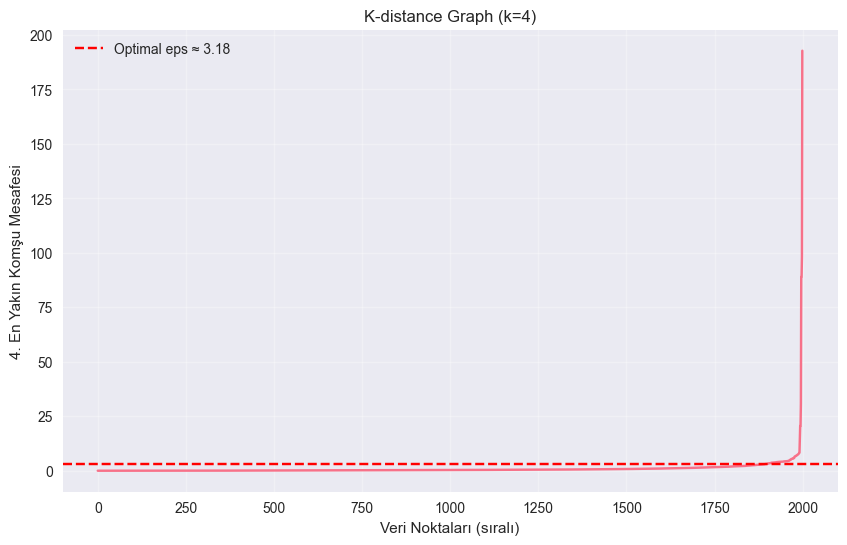

Önerilen eps değeri: 3.177


In [10]:
# DBSCAN parametrelerini optimize et
print("DBSCAN parametreleri optimize ediliyor...")

from sklearn.neighbors import NearestNeighbors

# Optimal eps değerini bul (k-distance graph)
sample_for_dbscan = X_train_normal[:2000]  # Hız için küçük sample

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(sample_for_dbscan)
distances, indices = neighbors_fit.kneighbors(sample_for_dbscan)

# 4. en yakın komşu mesafelerini sırala
distances = np.sort(distances[:, 4], axis=0)

# K-distance grafiği
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (k=4)')
plt.xlabel('Veri Noktaları (sıralı)')
plt.ylabel('4. En Yakın Komşu Mesafesi')
plt.grid(True, alpha=0.3)

# Elbow noktasını yaklaşık olarak bul
knee_point = int(len(distances) * 0.95)  # %95'lik dilim
optimal_eps = distances[knee_point]
plt.axhline(y=optimal_eps, color='red', linestyle='--', label=f'Optimal eps ≈ {optimal_eps:.2f}')
plt.legend()
plt.show()

print(f"Önerilen eps değeri: {optimal_eps:.3f}")

In [11]:
# DBSCAN ile anomali tespiti
print(f"DBSCAN clustering (eps={optimal_eps:.3f}) uygulanıyor...")

# DBSCAN'i normal veriler üzerinde eğit
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
normal_labels = dbscan.fit_predict(sample_for_dbscan)

# Küme sayısını ve noise noktalarını say
n_clusters = len(set(normal_labels)) - (1 if -1 in normal_labels else 0)
n_noise = list(normal_labels).count(-1)

print(f"Küme sayısı: {n_clusters}")
print(f"Noise noktaları: {n_noise} ({n_noise/len(normal_labels)*100:.1f}%)")

# Test verisi için anomali tespiti
# DBSCAN'de yeni noktalar için predict yok, mesafe tabanlı yaklaşım kullan
from sklearn.neighbors import NearestNeighbors

# Core noktaları bul
core_samples_mask = np.zeros_like(normal_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
core_samples = sample_for_dbscan[core_samples_mask]

# Test noktaları için en yakın core sample'a olan mesafeyi hesapla
if len(core_samples) > 0:
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(core_samples)
    distances_to_core, _ = nn.kneighbors(X_test_sample)
    anomaly_scores_dbscan = distances_to_core.flatten()
    
    # Threshold belirleme
    threshold_dbscan = np.percentile(anomaly_scores_dbscan, 95)
    predictions_dbscan = (anomaly_scores_dbscan > threshold_dbscan).astype(int)
    
    print(f"DBSCAN threshold: {threshold_dbscan:.3f}")
    print(f"Tespit edilen anomali sayısı: {sum(predictions_dbscan)}")
else:
    print("DBSCAN core sample bulamadı, parametreleri ayarlayın.")
    anomaly_scores_dbscan = np.zeros(len(X_test_sample))
    predictions_dbscan = np.zeros(len(X_test_sample))

DBSCAN clustering (eps=3.177) uygulanıyor...
Küme sayısı: 7
Noise noktaları: 83 (4.2%)
DBSCAN threshold: 6.381
Tespit edilen anomali sayısı: 499


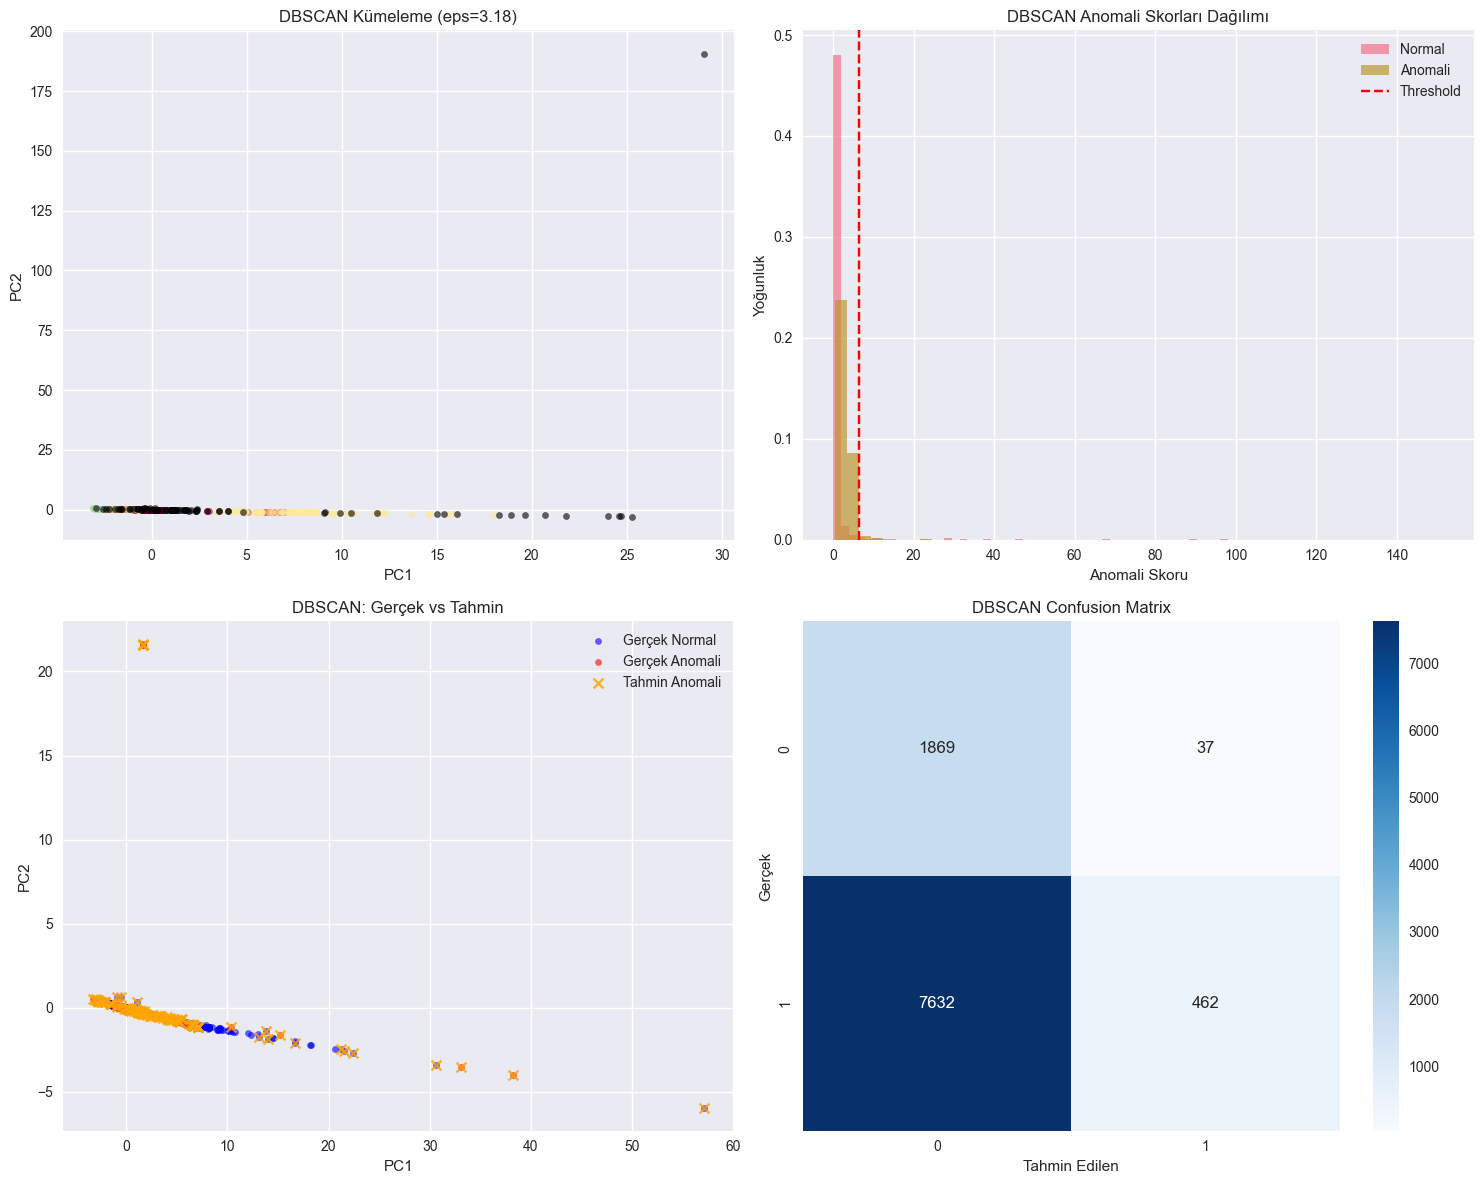

In [12]:
# DBSCAN sonuçlarını görselleştir
if len(core_samples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Normal veri kümeleme sonuçları (PCA)
    sample_pca = pca.transform(sample_for_dbscan)
    unique_labels = set(normal_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'  # Noise için siyah
        class_member_mask = (normal_labels == k)
        xy = sample_pca[class_member_mask]
        axes[0,0].scatter(xy[:, 0], xy[:, 1], c=[col], alpha=0.6, s=20)
    
    axes[0,0].set_title(f'DBSCAN Kümeleme (eps={optimal_eps:.2f})')
    axes[0,0].set_xlabel('PC1')
    axes[0,0].set_ylabel('PC2')
    
    # Anomali skorları dağılımı
    axes[0,1].hist(anomaly_scores_dbscan[y_test_sample == 0], bins=50, alpha=0.7, label='Normal', density=True)
    axes[0,1].hist(anomaly_scores_dbscan[y_test_sample == 1], bins=50, alpha=0.7, label='Anomali', density=True)
    axes[0,1].axvline(threshold_dbscan, color='red', linestyle='--', label='Threshold')
    axes[0,1].set_title('DBSCAN Anomali Skorları Dağılımı')
    axes[0,1].set_xlabel('Anomali Skoru')
    axes[0,1].set_ylabel('Yoğunluk')
    axes[0,1].legend()
    
    # Gerçek vs Tahmin edilen
    axes[1,0].scatter(X_test_pca[y_test_sample == 0, 0], X_test_pca[y_test_sample == 0, 1], 
                     alpha=0.6, label='Gerçek Normal', s=20, c='blue')
    axes[1,0].scatter(X_test_pca[y_test_sample == 1, 0], X_test_pca[y_test_sample == 1, 1], 
                     alpha=0.6, label='Gerçek Anomali', s=20, c='red')
    axes[1,0].scatter(X_test_pca[predictions_dbscan == 1, 0], X_test_pca[predictions_dbscan == 1, 1], 
                     alpha=0.8, label='Tahmin Anomali', s=50, c='orange', marker='x')
    axes[1,0].set_title('DBSCAN: Gerçek vs Tahmin')
    axes[1,0].set_xlabel('PC1')
    axes[1,0].set_ylabel('PC2')
    axes[1,0].legend()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_sample, predictions_dbscan)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
    axes[1,1].set_title('DBSCAN Confusion Matrix')
    axes[1,1].set_xlabel('Tahmin Edilen')
    axes[1,1].set_ylabel('Gerçek')
    
    plt.tight_layout()
    plt.show()

## 5. Isolation Forest

In [13]:
# Isolation Forest ile anomali tespiti
print("Isolation Forest uygulanıyor...")

# Model oluştur ve eğit
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
iso_forest.fit(X_train_normal)

# Test verisi üzerinde tahmin yap
anomaly_scores_iso = iso_forest.decision_function(X_test_sample)
predictions_iso = iso_forest.predict(X_test_sample)
predictions_iso = (predictions_iso == -1).astype(int)  # -1: anomali, 1: normal

print(f"Tespit edilen anomali sayısı: {sum(predictions_iso)}")
print(f"Anomali oranı: {sum(predictions_iso)/len(predictions_iso)*100:.1f}%")

Isolation Forest uygulanıyor...


Tespit edilen anomali sayısı: 8245
Anomali oranı: 82.5%


## 6. One-Class SVM

In [14]:
# One-Class SVM ile anomali tespiti
print("One-Class SVM uygulanıyor...")

# Model oluştur ve eğit (küçük sample ile)
oc_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
oc_svm.fit(X_train_normal[:5000])  # Hız için subset

# Test verisi üzerinde tahmin yap
anomaly_scores_svm = oc_svm.decision_function(X_test_sample)
predictions_svm = oc_svm.predict(X_test_sample)
predictions_svm = (predictions_svm == -1).astype(int)  # -1: anomali, 1: normal

print(f"Tespit edilen anomali sayısı: {sum(predictions_svm)}")
print(f"Anomali oranı: {sum(predictions_svm)/len(predictions_svm)*100:.1f}%")

One-Class SVM uygulanıyor...


Tespit edilen anomali sayısı: 8253
Anomali oranı: 82.5%


## 7. Local Outlier Factor (LOF)

In [15]:
# LOF ile anomali tespiti
print("Local Outlier Factor (LOF) uygulanıyor...")

# LOF modeli (novelty=True ile yeni veriler için kullanılabilir)
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
lof.fit(X_train_normal[:5000])  # Hız için subset

# Test verisi üzerinde tahmin yap
anomaly_scores_lof = lof.decision_function(X_test_sample)
predictions_lof = lof.predict(X_test_sample)
predictions_lof = (predictions_lof == -1).astype(int)  # -1: anomali, 1: normal

print(f"Tespit edilen anomali sayısı: {sum(predictions_lof)}")
print(f"Anomali oranı: {sum(predictions_lof)/len(predictions_lof)*100:.1f}%")

Local Outlier Factor (LOF) uygulanıyor...
Tespit edilen anomali sayısı: 8242
Anomali oranı: 82.4%


## 8. Algoritma Karşılaştırması

In [16]:
# Tüm algoritmaların performansını karşılaştır
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

algorithms = {
    'K-means': predictions_kmeans,
    'DBSCAN': predictions_dbscan,
    'Isolation Forest': predictions_iso,
    'One-Class SVM': predictions_svm,
    'LOF': predictions_lof
}

anomaly_scores = {
    'K-means': anomaly_scores_kmeans,
    'DBSCAN': anomaly_scores_dbscan,
    'Isolation Forest': -anomaly_scores_iso,  # Negatif çünkü düşük skor = yüksek anomali
    'One-Class SVM': -anomaly_scores_svm,
    'LOF': -anomaly_scores_lof
}

results = []

for name, pred in algorithms.items():
    if len(pred) > 0 and not np.all(pred == 0):
        accuracy = accuracy_score(y_test_sample, pred)
        precision = precision_score(y_test_sample, pred, zero_division=0)
        recall = recall_score(y_test_sample, pred, zero_division=0)
        f1 = f1_score(y_test_sample, pred, zero_division=0)
        
        # ROC AUC için anomali skorlarını kullan
        try:
            roc_auc = roc_auc_score(y_test_sample, anomaly_scores[name])
        except:
            roc_auc = 0.5
        
        results.append({
            'Algorithm': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Detected_Anomalies': sum(pred)
        })

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)
print("=== Algoritma Karsilastirmasi ===")
print(results_df.round(3))

=== Algoritma Karsilastirmasi ===
          Algorithm  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0           K-means     0.214      0.736   0.045     0.086    0.811   
1            DBSCAN     0.233      0.926   0.057     0.108    0.969   
2  Isolation Forest     0.975      0.976   0.994     0.985    0.944   
3     One-Class SVM     0.979      0.978   0.997     0.987    0.964   
4               LOF     0.980      0.979   0.997     0.988    0.974   

   Detected_Anomalies  
0                 500  
1                 499  
2                8245  
3                8253  
4                8242  


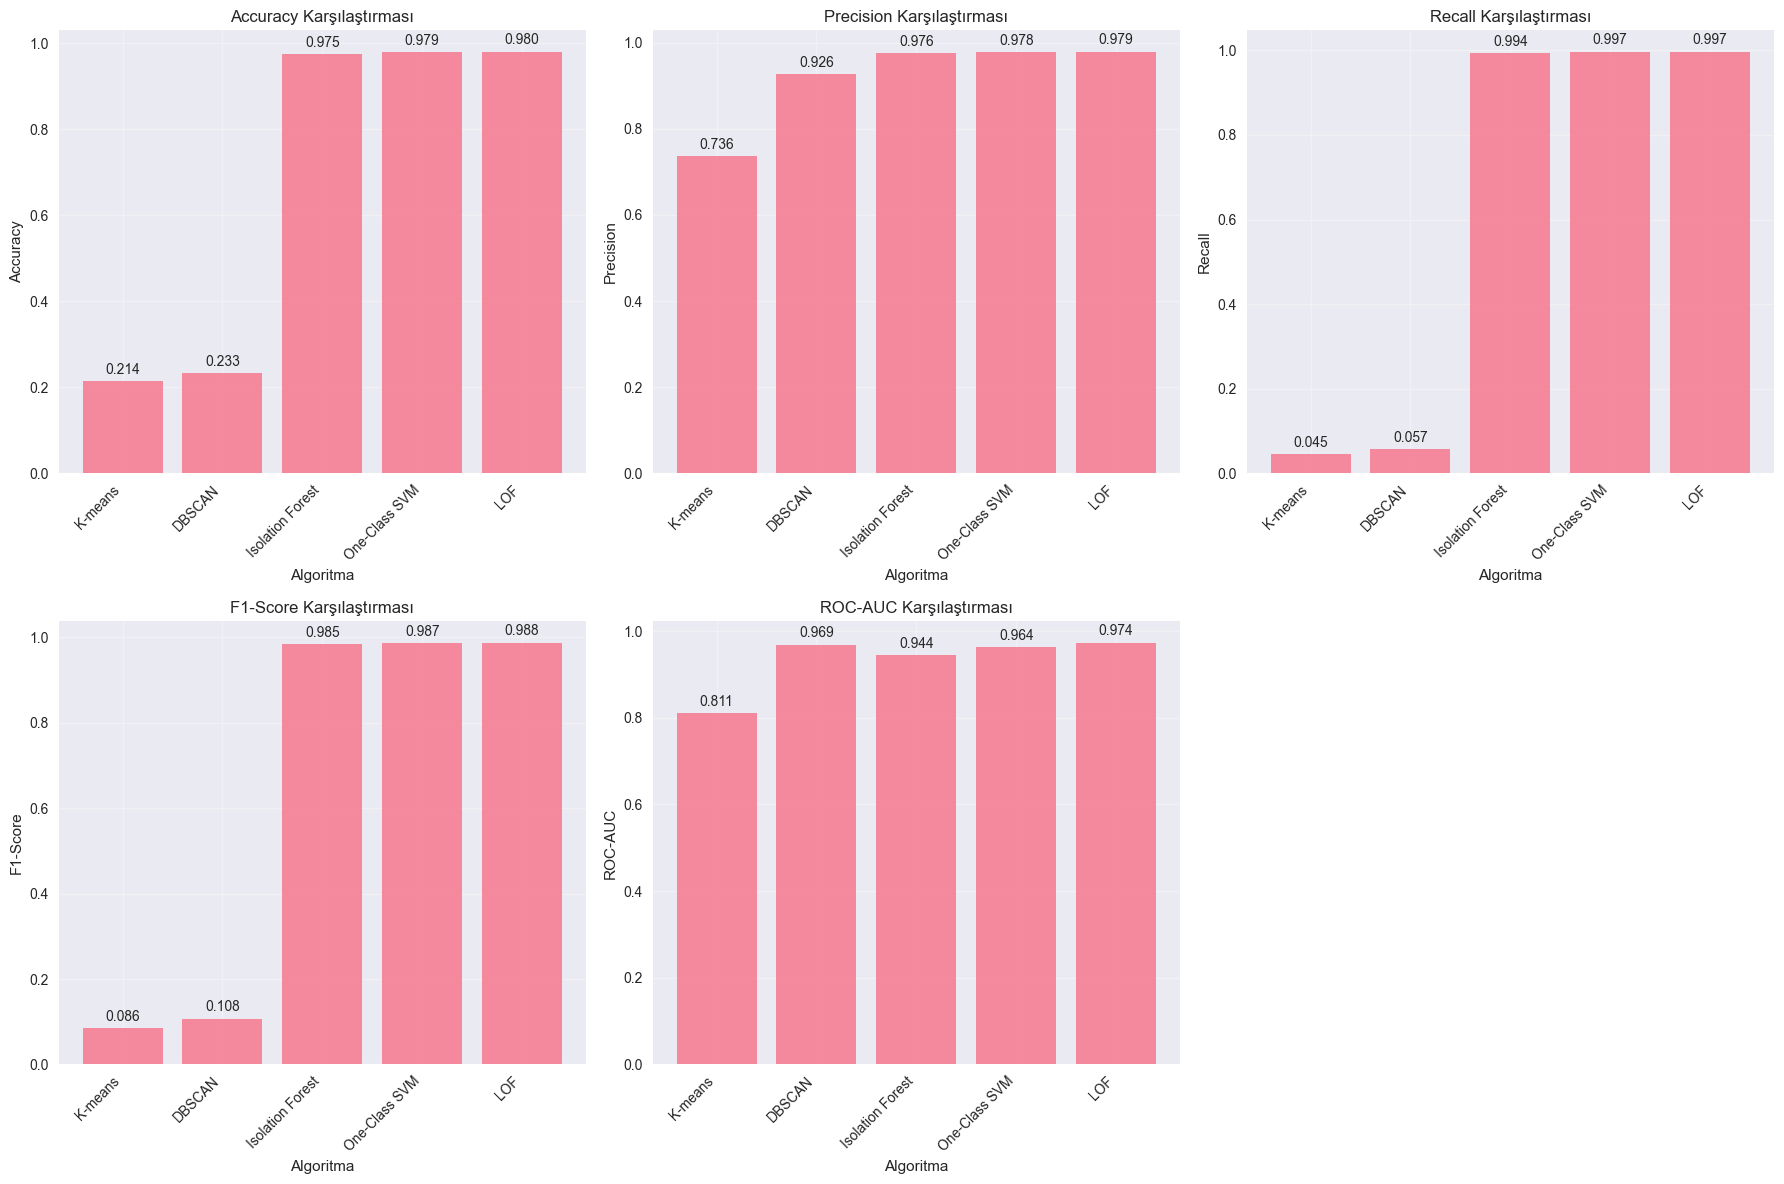

In [17]:
# Performans metrikleri görselleştirmesi
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    if i < len(axes):
        values = results_df[metric].values
        algorithms_list = results_df['Algorithm'].values
        
        bars = axes[i].bar(range(len(algorithms_list)), values, alpha=0.8)
        axes[i].set_title(f'{metric} Karşılaştırması')
        axes[i].set_xlabel('Algoritma')
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(range(len(algorithms_list)))
        axes[i].set_xticklabels(algorithms_list, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)
        
        # Değerleri bar üzerine yaz
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# Son subplot'u kaldır
if len(metrics) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [18]:
# En iyi algoritmaları belirle
print("=== SONUCLAR VE DEGERLENDIRME ===")
print("1. PERFORMANS SIRALAMASI:")

# F1-Score'a göre sırala
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"   En İyi F1-Score: {best_f1['Algorithm']} ({best_f1['F1-Score']:.3f})")

# ROC-AUC'ye göre sırala
best_auc = results_df.loc[results_df['ROC-AUC'].idxmax()]
print(f"   En İyi ROC-AUC: {best_auc['Algorithm']} ({best_auc['ROC-AUC']:.3f})")

# Precision'a göre sırala
best_precision = results_df.loc[results_df['Precision'].idxmax()]
print(f"   En İyi Precision: {best_precision['Algorithm']} ({best_precision['Precision']:.3f})")

# Recall'a göre sırala
best_recall = results_df.loc[results_df['Recall'].idxmax()]
print(f"   En İyi Recall: {best_recall['Algorithm']} ({best_recall['Recall']:.3f})")

print("2. GENEL DEĞERLENDİRME:")
print("   - Yüksek Precision: False positive'leri azaltır")
print("   - Yüksek Recall: Gerçek anomalileri kaçırmaz")
print("   - F1-Score: Precision ve Recall'un dengeli kombinasyonu")
print("   - ROC-AUC: Genel sınıflandırma performansı")

=== SONUCLAR VE DEGERLENDIRME ===
1. PERFORMANS SIRALAMASI:
   En İyi F1-Score: LOF (0.988)
   En İyi ROC-AUC: LOF (0.974)
   En İyi Precision: LOF (0.979)
   En İyi Recall: LOF (0.997)
2. GENEL DEĞERLENDİRME:
   - Yüksek Precision: False positive'leri azaltır
   - Yüksek Recall: Gerçek anomalileri kaçırmaz
   - F1-Score: Precision ve Recall'un dengeli kombinasyonu
   - ROC-AUC: Genel sınıflandırma performansı


In [19]:
# Ozet tablo
print("=== OZET TABLO ===")
summary_df = results_df.copy()
summary_df['Rank_F1'] = summary_df['F1-Score'].rank(ascending=False).astype(int)
summary_df['Rank_AUC'] = summary_df['ROC-AUC'].rank(ascending=False).astype(int)
summary_df['Overall_Rank'] = (summary_df['Rank_F1'] + summary_df['Rank_AUC']) / 2

# Sırala
summary_df = summary_df.sort_values('Overall_Rank')

print(summary_df[['Algorithm', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall', 'Overall_Rank']].round(3))

print("=== ÖNERİLER ===")
print("1. En iyi genel performans için:", summary_df.iloc[0]['Algorithm'])
print("2. Yüksek hassasiyet için: Precision değeri en yüksek algoritma")
print("3. Anomali kaçırma riskini minimize etmek için: Recall değeri en yüksek algoritma")
print("4. Dengeli performans için: F1-Score değeri en yüksek algoritma")

=== OZET TABLO ===
          Algorithm  F1-Score  ROC-AUC  Precision  Recall  Overall_Rank
4               LOF     0.988    0.974      0.979   0.997           1.0
3     One-Class SVM     0.987    0.964      0.978   0.997           2.5
1            DBSCAN     0.108    0.969      0.926   0.057           3.0
2  Isolation Forest     0.985    0.944      0.976   0.994           3.5
0           K-means     0.086    0.811      0.736   0.045           5.0
=== ÖNERİLER ===
1. En iyi genel performans için: LOF
2. Yüksek hassasiyet için: Precision değeri en yüksek algoritma
3. Anomali kaçırma riskini minimize etmek için: Recall değeri en yüksek algoritma
4. Dengeli performans için: F1-Score değeri en yüksek algoritma
